# Siamese Net Classification Training Env

I am running this training in an AWS ml.g4dn.xlarge sagemaker notebook instance. 

Load in Cifar-100 dataset

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Define a transform to normalize the data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# Load CIFAR100 training data
trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)

# Load CIFAR100 test data
testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


Use Custom Dataloader to ensure like image pairs are evenly split with unlike image pairs during training.

In [2]:
from dataloader import SiameseClfDataloader

batch_size = 256

trainloader = DataLoader(SiameseClfDataloader(trainset), batch_size=batch_size, shuffle=True)
testloader = DataLoader(SiameseClfDataloader(testset), batch_size=batch_size, shuffle=True)

Get Classes

In [3]:
from typing import List

# Classes in CIFAR100
train_classes : List[str] = trainset.classes
test_classs : List[str] = testset.classes

Plot Some Images

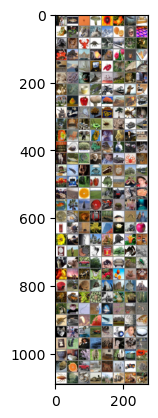

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy() # convert to numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # convert from tensor image

# Get some random training images
dataiter = iter(trainloader)
imgs1, imgs2, labels = dataiter.__next__()

# Show images
imshow(torchvision.utils.make_grid(imgs1))

Instantiate Model

In [5]:
from siamese_net import SiameseNet, SiameseNetConfig

netConfig = SiameseNetConfig(
    input_shape = (3, 32, 32),
    embedding_size = 128,
    initial_channels = 32,
    channel_increase_factor = 2,
    num_conv_blocks = 4,
    dropout_rate = 0.5
    )

net = SiameseNet(netConfig)

In [6]:
print(net)

SiameseNet(
  (conv_blocks): ModuleList(
    (0): ConvBlock(
      (conv_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBlock(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode

In [7]:
# print number of parameters
total_params = sum(p.numel() for p in net.parameters())
print(f"{total_params:,} total parameters.")

1,305,376 total parameters.


In [8]:
# run an example forward pass using the dataloader
dataiter = iter(trainloader)
imgs, imgs2, labels = dataiter.__next__()

# run the forward pass
outputs = net(imgs1, imgs2)

print(f"input shape: {imgs1.shape} and {imgs2.shape}")
print(f"output shape: {outputs[0].shape} and {outputs[1].shape}")   

input shape: torch.Size([256, 3, 32, 32]) and torch.Size([256, 3, 32, 32])
output shape: torch.Size([256, 128]) and torch.Size([256, 128])


# Training

In [9]:
from train import Trainer, TrainConfig

lr = 0.0001

trainerConfig = TrainConfig(
    model=net,
    trainloader=trainloader,
    testloader=testloader,
    epochs=60,
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    contrastive_margin=0.2,
    optimizer=torch.optim.Adam(net.parameters(), lr=lr),
    patience=7,
    es_min_delta=0.0
)

trainer = Trainer(trainerConfig)


In [10]:
# NOTE: I am using cosine similarity in the trainer to comput accuracy with a threshold of 0.5
# This might not be the most informative metric, as I am training specifically for similarity, 
# trust the loss metric more than accuracy. 

trainer.train()

Model sent to cuda:0
Epoch 1: Training Loss: 0.020848196384744073, Training Accuracy: 0.49892, Test Loss: 0.00012370244367048143, Test Accuracy: 0.4991
Epoch 2: Training Loss: 0.0045475113640387295, Training Accuracy: 0.50094, Test Loss: 4.244199953973293e-05, Test Accuracy: 0.4966
Epoch 3: Training Loss: 0.0026657053504652362, Training Accuracy: 0.49966, Test Loss: 2.2358674323186277e-05, Test Accuracy: 0.5013
Epoch 4: Training Loss: 0.0018126275473540382, Training Accuracy: 0.49856, Test Loss: 1.3796816347166896e-05, Test Accuracy: 0.5015
Epoch 5: Training Loss: 0.001322906729836511, Training Accuracy: 0.49984, Test Loss: 9.570881957188249e-06, Test Accuracy: 0.5046
Epoch 6: Training Loss: 0.000989968120773817, Training Accuracy: 0.5, Test Loss: 6.986164953559637e-06, Test Accuracy: 0.5088
Epoch 7: Training Loss: 0.0007561701801320424, Training Accuracy: 0.50088, Test Loss: 5.403801333159209e-06, Test Accuracy: 0.5012
Epoch 8: Training Loss: 0.0005812534981654311, Training Accuracy: 

In [11]:
# save the best model
best_model_state_dict = trainer.early_stopping.best_model
torch.save(best_model_state_dict, 'best_model.pth')


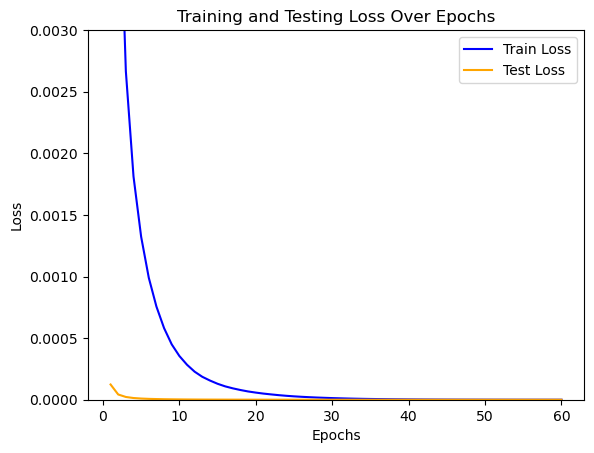

In [24]:
import matplotlib.pyplot as plt

def plot_loss(train_loss, test_loss, x_min=None, x_max=None, y_min=None, y_max=None):
    epochs = range(1, len(train_loss) + 1)

    plt.plot(epochs, train_loss, label='Train Loss', color='blue')
    plt.plot(epochs, test_loss, label='Test Loss', color='orange')
    plt.title('Training and Testing Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Set x and y axis limits if provided
    if x_min is not None or x_max is not None:
        plt.xlim(x_min, x_max)
    if y_min is not None or y_max is not None:
        plt.ylim(y_min, y_max)

    plt.show()

# Example usage:
plot_loss(trainer.train_loss, trainer.test_loss, y_min=0, y_max=0.003)
